### Uploading to S3

In [10]:
from utils import *

import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

prefix='dengai'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

train_path  = sagemaker_session.upload_data(TRAIN_JSON, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(TEST_JSON,  bucket=bucket, key_prefix=test_prefix)

### Creating training job

In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator

image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar') 
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

freq='W'

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(PREDICTION_LENGTH),
    "context_length": str(CONTEXT_LENGTH),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

estimator.set_hyperparameters(**hyperparameters)


In [12]:
data_channels = {
    "train": train_path,
#    "test": test_path
}

estimator.fit(inputs=data_channels)

2020-04-07 13:07:38 Starting - Starting the training job...
2020-04-07 13:07:39 Starting - Launching requested ML instances...
2020-04-07 13:08:34 Starting - Preparing the instances for training......
2020-04-07 13:09:22 Downloading - Downloading input data
2020-04-07 13:09:22 Training - Downloading the training image.....Arguments: train
[04/07/2020 13:10:15 INFO 140502386652992] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[04/07/2020 13:10:15 I

### If we want to skip training and reuse a previously trained model

In [13]:
sagemaker_session.list_s3_files(bucket, prefix)

['dengai/batch-inference/test.json.out',
 'dengai/output/forecasting-deepar-2020-04-02-20-36-06-182/output/model.tar.gz',
 'dengai/output/forecasting-deepar-2020-04-07-13-07-38-457/output/model.tar.gz',
 'dengai/test/test.json',
 'dengai/train/test.json',
 'dengai/train/train.json',
 'dengai/train/train_out.json']

In [4]:
from sagemaker.model import Model

model_file = 'dengai/output/forecasting-deepar-2020-04-02-20-36-06-182/output/model.tar.gz'
model_s3_path = f's3://{bucket}/{model_file}'

model = Model(model_data=model_s3_path,
              image=image_name,
             role=role)

## Testing our model

In [14]:
s3_batch_output_path = 's3://{}/{}/batch-inference'.format(bucket, prefix)

# uncomment to  use freshly trained model
model = estimator

transformer = model.transformer(instance_count=1,
                                instance_type='ml.m4.xlarge',
                                strategy='SingleRecord',
                                assemble_with='Line',
                                output_path=s3_batch_output_path)


transformer.transform(data=test_path, data_type='S3Prefix', content_type=None, split_type='Line')
transformer.wait()

........................
Arguments: serve
No handlers could be found for logger "root"
[04/07/2020 13:33:33 INFO 140192894330688] Estimated memory required per model 125MB.
[04/07/2020 13:33:33 INFO 140192894330688] Estimated available memory 14745MB.
[04/07/2020 13:33:33 INFO 140192894330688] Estimated maximum number of workers for the available memory is 117.
[04/07/2020 13:33:33 INFO 140192894330688] Using 4 workers
[04/07/2020 13:33:33 INFO 140192894330688] loading entry points
[04/07/2020 13:33:33 INFO 140192894330688] Prediction endpoint operating in batch mode
[04/07/2020 13:33:33 INFO 140192894330688] loaded request iterator application/jsonlines
[04/07/2020 13:33:33 INFO 140192894330688] loaded response encoder application/jsonlines
[04/07/2020 13:33:33 INFO 140192894330688] loaded model class model
[04/07/2020 13:33:33 WARNING 140192894330688] Requesting context without setting the requested num of gpus. Using 'auto'
[04/07/2020 13:33:33 INFO 140192894330688] nvidia-smi took:

In [15]:
sagemaker_session.list_s3_files(bucket, prefix)

['dengai/batch-inference/test.json.out',
 'dengai/output/forecasting-deepar-2020-04-02-20-36-06-182/output/model.tar.gz',
 'dengai/output/forecasting-deepar-2020-04-07-13-07-38-457/output/model.tar.gz',
 'dengai/test/test.json',
 'dengai/train/test.json',
 'dengai/train/train.json',
 'dengai/train/train_out.json']

In [17]:
predictions = sagemaker_session.read_s3_file(bucket, 'dengai/batch-inference/test.json.out')

In [18]:
# helper function to decode JSON prediction
def unjson_prediction(predictions):
    '''Accepts a JSON prediction and returns a list of quantiles for prediction.
    '''
    prediction_data = json.loads(predictions)
    predictions_quantiles = pd.DataFrame(prediction_data['quantiles'])
    return predictions_quantiles

In [19]:
# get quantiles/predictions
prediction_list = unjson_prediction(predictions)
prediction_list.head()

,0.9,0.8,0.1,0.3,0.2,0.5,0.4,0.7,0.6
0,38.914806,34.621395,11.778447,21.385513,18.702026,26.717186,23.380857,30.991985,28.576336
1,54.564434,49.880524,17.470640,32.574280,24.212112,38.506138,35.868717,44.616009,42.606930
2,82.712952,69.416451,23.430340,45.514503,38.710178,52.051044,49.151989,60.263771,55.796577
3,83.430412,70.830032,24.625181,43.656368,33.206352,55.616829,50.450844,64.554413,60.091934
4,64.989075,60.550781,38.338104,45.741776,43.701447,53.793194,51.944233,58.207951,55.989117


In [21]:
import matplotlib.pyplot as plt

# display the prediction median against the actual data
def display_quantiles(prediction, target_ts=None):
    plt.figure(figsize=(12,6))
    # get the target month of data
    if target_ts is not None:
        target = target_ts[k][-prediction_length:]
        plt.plot(range(len(target)), target, label='target')
    # get the quantile values at 10 and 90%
    p10 = prediction['0.1']
    p90 = prediction['0.9']
    # fill the 80% confidence interval
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    # plot the median prediction line
    prediction['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

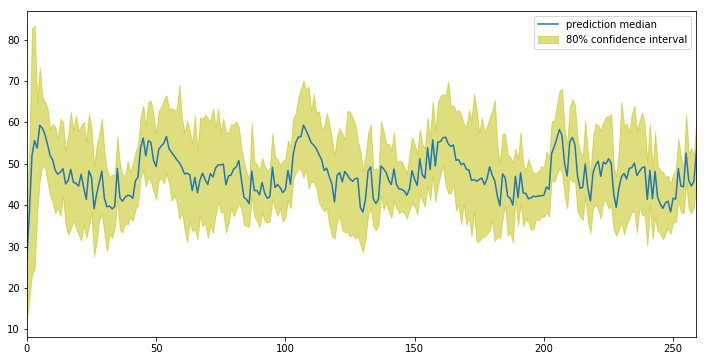

In [22]:
display_quantiles(prediction_list, None)

In [23]:
train_data = read_json(TRAIN_JSON)

In [28]:
prediction_list.shape

(260, 9)